# This is a notebook for testing my implementation of LSPI

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline



In [2]:
env = gym.make('CartPole-v0')
#env = gym.make("NChain-v0")
env.reset()

array([-0.01889356, -0.03887042, -0.01519252,  0.01319667])

In [3]:
env.observation_space.sample()

array([  4.68609638e-01,   1.46450285e+38,   8.60908446e-02,
         3.05459097e+37])

# Implementation

In [48]:
def LSPI(basis_functions, gamma, epsilon, w):
    '''
    Compute the parameters of the policy, w, using the LSPI algorithm.
    
    Inputs:
    sample: list of tuples of the form (s,a,r,s')
    basis_functions: list of basis functions
    gamma: float, discount factor
    epsilon: float, convergence threshold
    w: intial policy parameter vector
    
    Outputs:
    w: the converged policy paramters
    '''
    w0 = []
    samples = generate_samples(1000, 6)
    #while True:
    for i in tqdm(range(100)):
        w_prev = w
        #w = LSTDQ(samples, basis_functions, gamma, w)
        w = LSTDQ_OPT(samples, basis_functions, gamma, w)
        
        
        if converged(w, w_prev, epsilon):
            break 
        else:
            w_prev = w
        w0.append(w[0])
        #print w
    return w, w0

def converged(w, w_prev, epsilon):
    '''
    Determines if the policy parameters have converged based
    on whether or not the norm of the difference of w
    is less than the threshold epsilon.
    
    Inputs:
    w: a policy parameter vector
    w_prev: the policy parameter vetor from a previous iteration.
    epsilon: float, convergence threshold
    '''
    return np.linalg.norm(w - w_prev) < epsilon

def LSTDQ(samples, basis_functions, gamma, w):
    '''
    Simple version of LSTDQ
    '''
    k = len(basis_functions)
    #A = np.zeros((k,k)), this might not have an inverse, use the next line instead
    A = np.identity(k) * 0.01
    b = np.zeros(k)
    
    #samples[np.random.choice(len(samples), 100, replace=False)]
    
    for s, a, r, sp in samples:
        phi = compute_phi(s,a, basis_functions)
        phi_p = compute_phi(sp, get_policy_action(sp, w, basis_functions), basis_functions)

        A += np.outer(phi, (phi - gamma*phi_p))
        b = b + phi*r
    
    
    w = np.dot(np.linalg.inv(A),b)
    return w
    
    

    
    
def LSTDQ_OPT(samples, basis_functions, gamma, w, sigma=0.1):
    '''
    Computes an approximation of the policy parameters based
    on the LSTDQ-OPT algorithm presented in the paper.
    
    Inputs:
    sample: list of tuples of the form (s,a,r,s')
    basis_functions: list of basis functions
    gamma: float, discount factor
    epsilon: float, convergence threshold
    w: intial policy parameter vector
    
     sigma: small positive float.
    '''
    k = len(basis_functions)
    B = np.identity(k) * float(1/sigma)
    b = np.zeros(k)
    
    for s, a, r, sp in samples:
        phi = compute_phi(s,a, basis_functions)
        phi_p = compute_phi(sp, get_policy_action(sp, w, basis_functions), basis_functions)

        # Some computations that can be reused in the computation
        Bphi = np.dot(B, phi)
        phi_t =  (phi - gamma*phi_p).T
        

        top = np.dot(np.outer(Bphi, phi_t), B)
        bottom = 1 + np.dot(phi_t, Bphi)
        B = B - top/bottom
        
        b = b + phi*r
    
    w = np.dot(B,b)
        
        
    return w
       

def compute_phi(s,a, basis_functions):
    '''
    Computes the vector ϕ(s,a) according to the basis function ϕ_1...ϕ_k
    
    Inputs:
    s: state
    a: action
    basis_functions: list of basis functions that operate on s and a
    
    Outputs:
    ϕ(s,a), a vector where each entry is the result of one of the basis functions.
    '''
    phi= np.array([bf(s,a) for bf in basis_functions])
    return phi
    
def get_policy_action(s, w, basis_functions):
    '''
    Given a parameterization for the policy,
    reconstruct the policy and querery it to get 
    the optimal action for state s. That is,
    the argmax over actions of ϕ(s,a).w
    
    Inputs:
    s: state
    w: policy parameters
    action_space: set of all possible actions
    
    Outputs:
    action a that the policy says is best
    '''
    a_max = None
    max_score = float("-inf")
    
    # TODO: don't hard code action space
    action_space = [0,1]
    
    # Search action space for most valuable action
    for a in action_space:
        #print "phi:", compute_phi(s,a, basis_functions)
        #print "w:",w
        score = np.dot(compute_phi(s,a, basis_functions), w)
        # update if we found something better
        if score > max_score:
            max_score = score
            a_max = a
    #print "best score:",max_score
    return a_max
    

def get_basis_functions():
    '''
    Define some basis functions and return them in a list
    '''
    bfs = []
    random_points = []

    # Environment bounds
    #high: [  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
    #low:  [ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]

    s1 = np.array([1,1,1,1])
    s2 = np.array([0,0,0,0])
    s3 = np.array([1,0,1,0])
    s4 = np.array([-1,-1,0,-1])
    s5 = np.array([-1 ,1, 0, 1])
    s6 = np.array([1 ,- 1, 0, 1])
    s7 = np.array([1 , 0, 0, -1])

    e = 1
    s1 = np.array([0,0,0,0])
    s2 = np.array([0.5,0,0,0])
    s3 = np.array([1,0,0,0])
    s4 = np.array([1.5,0,0,0])
    s5 = np.array([2,0,0,0])
    s6 = np.array([-0.5,0,0,0])
    s7 = np.array([-1.0,0,0,0])
    s8 = np.array([-1.5,0,0,0])
    s9 = np.array([-2.0,0,0,0])
    
    s10 = np.array([0,-1,0,0])
    s11 = np.array([0,-0.5,0,0])
    s12 = np.array([0,0.5,0,0])
    s13 = np.array([0,1,0,0])
    s14 = np.array([0,0,0,-1])
    s15 = np.array([0,0,0,-0.5])
    s16 = np.array([0,0,0,0.5])
    
   
    
    
    bf1 = lambda s,a: 1
    
#     bf2 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
#     bf3 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s1)/2.0)

#     bf4 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s2)/2.0)
#     bf5 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s2)/2.0)

#     bf6 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s3)/2.0)
#     bf7 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s3)/2.0)
    
#     bf8 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s4)/2.0)
#     bf9 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s4)/2.0)
    
#     bf10 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s5)/2.0)
#     bf11 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s5)/2.0)
    
#     bf12 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s6)/2.0)
#     bf13 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s6)/2.0)
    
#     bf14 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s7)/2.0)
#     bf15 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s7)/2.0)
    
#     bf16 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s8)/2.0)
#     bf17 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s8)/2.0)
    
#     bf18 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s9)/2.0)
#     bf19 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s9)/2.0)
    
#     bf20 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s10)/2.0)
#     bf21 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s10)/2.0)
    
#     bf22 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s11)/2.0)
#     bf23 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s11)/2.0)
    
#     bf24 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s12)/2.0)
#     bf25 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s12)/2.0)
    
#     bf26 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s13)/2.0)
#     bf27 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s13)/2.0)
    
#     bf28 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s14)/2.0)
#     bf29 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s14)/2.0)
    
#     bf30 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s15)/2.0)
#     bf31 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s15)/2.0)
    
#     bf32 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s16)/2.0)
#     bf33 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s16)/2.0)
    
    
    s1 = np.zeros(4)
    bf2 = lambda s,a: np.linalg.norm(s)*a
    bf3 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
    bf4 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
    
    
#     bf6 = lambda s,a: int(a==1)*np.exp( - np.linalg.norm(s-s3)/2.0)
#     bf7 = lambda s,a: int(a==0)*np.exp( - np.linalg.norm(s-s1)/2.0)
#    bfs = [bf1,bf2,bf3,bf4,bf5]
    #bfs = [bf1,bf2,bf3, bf4, bf5, bf6, bf7]
    #bfs = [bf1,bf2,bf3,bf4, bf5, bf6, bf7, bf8, bf9, bf10, bf11, bf12, bf13, bf14, bf15, bf16, bf17, bf18, bf19, bf20, bf21, bf22, bf23, bf24, bf25, bf26, bf27, bf28, bf29, bf30, bf31, bf32, bf33]
    #bfs = [bf1,bf2,bf3,bf4,bf5, bf6, bf7, bf8,bf9]
    bfs = [bf1,bf2,bf3,bf4]
    return bfs


def generate_samples(n_samples, n_steps=100):
    samples = []
    for i in range(n_samples):
        env.reset()
        for j in range(n_steps):
            s = list(env.env.state)
            a = env.action_space.sample()
            sp,r, _,_ = env.step(a)
            
            sample = (s, a, r, sp)
            samples.append(sample)

    return np.array(samples)
    

In [49]:
np.zeros(4)

array([ 0.,  0.,  0.,  0.])

In [50]:
print env.observation_space.high
print env.observation_space.low

[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


In [54]:
bfs = get_basis_functions()


gamma, epsilon, k = 0.95, 0.0001, len(bfs)
w = np.zeros(k)
w_est, w0 = LSPI(bfs, gamma, epsilon, w)
print w_est







  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:00<01:12,  1.36it/s]



  2%|▏         | 2/100 [00:01<01:10,  1.39it/s]



  3%|▎         | 3/100 [00:02<01:08,  1.42it/s]




[  2.00069918e+01   3.45918613e-03   1.09700026e-03   1.09700026e-03]


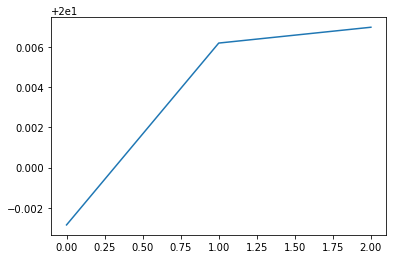

In [55]:
plt.plot(w0)

In [64]:
env.action_space.sample()

0

In [56]:
num_steps = []
for i_episode in range(100):
    observation = env.reset()
    print "--------"
    t = 0
    while True:
        t+=1
#    for t in range(500):
        env.render()
        action = get_policy_action(env.env.state, w_est, bfs)
        #action = env.action_space.sample()
       # print action
        observation, reward, done, info = env.step(action)
        #print observation
        if done:
#             print "reward:",reward
            num_steps.append(t)
            print("Episode finished after {} timesteps".format(t+1))
            break

--------
Episode finished after 26 timesteps
--------
Episode finished after 26 timesteps
--------
Episode finished after 26 timesteps
--------
Episode finished after 28 timesteps
--------
Episode finished after 26 timesteps
--------
Episode finished after 25 timesteps
--------
Episode finished after 28 timesteps
--------
Episode finished after 33 timesteps
--------
Episode finished after 22 timesteps
--------
Episode finished after 26 timesteps
--------
Episode finished after 28 timesteps
--------
Episode finished after 24 timesteps
--------
Episode finished after 22 timesteps
--------
Episode finished after 22 timesteps
--------
Episode finished after 24 timesteps
--------
Episode finished after 19 timesteps
--------
Episode finished after 23 timesteps
--------
Episode finished after 29 timesteps
--------
Episode finished after 30 timesteps
--------
Episode finished after 26 timesteps
--------
Episode finished after 23 timesteps
--------
Episode finished after 20 timesteps
--------
E

(array([ 26.,  31.,  24.,  10.,   2.,   2.,   3.,   0.,   0.,   2.]),
 array([  8. ,  13.9,  19.8,  25.7,  31.6,  37.5,  43.4,  49.3,  55.2,
         61.1,  67. ]),
 <a list of 10 Patch objects>)

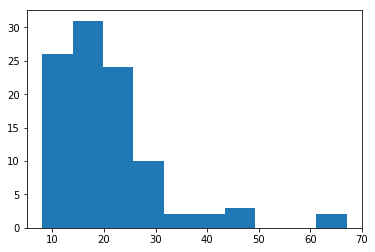

In [8]:
plt.hist(num_steps)

(array([  9.,   2.,  10.,  24.,  24.,   8.,  10.,   9.,   2.,   2.]),
 array([  48. ,   58.5,   69. ,   79.5,   90. ,  100.5,  111. ,  121.5,
         132. ,  142.5,  153. ]),
 <a list of 10 Patch objects>)

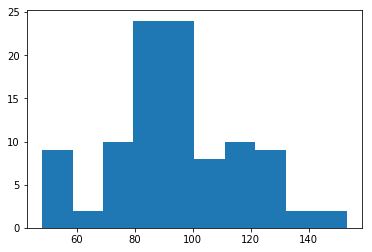

In [43]:
plt.hist(num_steps)